In [266]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Make pngs for Google Image Embeddings

In [1]:
import os
from pathlib import Path

import pytorch_lightning as pl
import torch
import wandb
from sdofm import utils
from sdofm.datasets import SDOMLDataModule
from sdofm.pretraining import SAMAE

In [268]:
import omegaconf
from sdofm.datasets import SDOMLDataModule, HelioProjectedSDOMLDataModule, NonLinearSDOMLDataModule, TimestampedSDOMLDataModule
import os

# cfg = omegaconf.OmegaConf.load("../experiments/pretrain_32.2M_samae_tpu_sweep.yaml")
cfg_path = "../experiments/for_google_emb.yaml"

# cfg_path = "../experiments/pretrain_nvae.yaml"
cfg = omegaconf.OmegaConf.load(cfg_path)

data_module = TimestampedSDOMLDataModule(
# data_module = NonLinearSDOMLDataModule(
# data_module = HelioProjectedSDOMLDataModule(
    # hmi_path=os.path.join(
    #     cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),
    # aia_path=None,
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
    num_frames=cfg.data.num_frames,
    drop_frame_dim=cfg.data.drop_frame_dim,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [269]:
data = next(iter(data_module.valid_ds))

KeyboardInterrupt: 

In [ ]:
data["timestamps"]

['2015-03-01 00:00:00']

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data['image_stack'].shape

(9, 1, 512, 512)

In [ ]:
import sunpy.visualization.colormaps as sunpycm
cms = [
    # sunpycm.cmlist.get("hmimag"),
    # sunpycm.cmlist.get("hmimag"),
    # sunpycm.cmlist.get("hmimag"),
    sunpycm.cmlist.get("sdoaia94"),
    sunpycm.cmlist.get("sdoaia131"),
    sunpycm.cmlist.get("sdoaia171"),
    sunpycm.cmlist.get("sdoaia193"),
    sunpycm.cmlist.get("sdoaia211"),
    sunpycm.cmlist.get("sdoaia304"),
    sunpycm.cmlist.get("sdoaia335"),
    sunpycm.cmlist.get("sdoaia1600"),
    sunpycm.cmlist.get("sdoaia1700"),
]
plt.imshow(data['image_stack'][0,4,:,:], cmap=cms[0])
# plt.imsave("imgs_for_google_emb/a.png", data['image_stack'][0,4,:,:], cmap=cms[4])

IndexError: index 4 is out of bounds for axis 1 with size 1

In [ ]:
names = [
    "94",
    "131",
    "171",
    "193",
    "211",
    "304",
    "335",
    "1600",
    "1700"
]

for r in iter(data_module.valid_ds):
    imgs, timestamp = r['image_stack'], r['timestamps'][0].replace(" ", "_")
    for i in range(9):
        plt.imsave(f"imgs_for_google_emb/{timestamp}-{names[i]}.png", data['image_stack'][i,0,:,:], cmap=cms[0])

Upload those to a GCP Bucket (done on cli)

### Send API requests

In [169]:
import requests

def make_data(file):
  return {
    "instances": [
      {
        "image": {
          "gcsUri": f"gs://sdofm-vertexai-emb-test/{file}.png",
        },
      },
    ],
    "parameters": {
      "dimension": 1408
    }
  }

In [177]:
import glob
from time import sleep
import dill as pickle
import numpy as np
import requests

files = glob.glob("imgs_for_google_emb/*.png")
import subprocess
# result = subprocess.run('gcloud auth print-access-token'.split(' '), stdout=subprocess.PIPE).stdout
# print(result.stdout)

wav_map = {
    "94": 0,
    "131": 1,
    "171": 2,
    "193": 3,
    "211": 4,
    "304": 5,
    "335": 6,
    "1600": 7,
    "1700": 8
}

# expensive_results = {}

c = 0
for i, f in enumerate(files):
    if ":12:00" in f:
        c += 1
        # continue
        part = f.replace("imgs_for_google_emb/", '').replace(".png", "")
        wav = part.split('-')[-1]
        ts = ''.join(part.split('-')[:-1])
        if ts not in expensive_results:
            expensive_results[ts] = [None]*9

        auth = subprocess.run('gcloud auth print-access-token'.split(' '), stdout=subprocess.PIPE).stdout.decode('utf-8').replace('\n', '')

        if expensive_results[ts][wav_map[wav]] is None:
            r = requests.post(
                'https://us-central1-aiplatform.googleapis.com/v1/projects/sdo-fm-2024/locations/us-central1/publishers/google/models/multimodalembedding@001:predict',
                headers={
                    "Authorization": f"Bearer {auth}",
                    "Content-Type": "application/json; charset=utf-8"
                },
                json=make_data(part)
            )
            if r.status_code == 200: 
                expensive_results[ts][wav_map[wav]] = np.array(r.json()['predictions'][0]['imageEmbedding'])
            else:
                print("Error on", part)

        if c % 40 == 0:
            print(f"{c} completed which is {100*(i/len(files)):02f}% completed")
            with open('google_embeddings_moar.pkl', 'wb') as file:
                pickle.dump(expensive_results, file)

        sleep(0.5)
print("Complete")

40 completed which is 0.003306% completed
80 completed which is 0.007111% completed
120 completed which is 0.010564% completed
160 completed which is 0.014646% completed
200 completed which is 0.018654% completed
240 completed which is 0.023050% completed
280 completed which is 0.026928% completed
320 completed which is 0.031342% completed
360 completed which is 0.035941% completed
400 completed which is 0.039709% completed
440 completed which is 0.044031% completed
480 completed which is 0.047688% completed
520 completed which is 0.051732% completed
560 completed which is 0.054835% completed
600 completed which is 0.058437% completed
640 completed which is 0.062463% completed
680 completed which is 0.065972% completed
720 completed which is 0.069315% completed
760 completed which is 0.072787% completed
800 completed which is 0.077054% completed
840 completed which is 0.080323% completed
880 completed which is 0.083223% completed
920 completed which is 0.087378% completed
960 completed

In [167]:
pickle_dict(expensive_results, "more_expensive_results_hourly")

'imgs_for_google_emb/2015-03-29_01:00:00-171.png'

In [1]:
# !gcloud auth print-access-token

In [ ]:
# with open('google_embeddings.pkl', 'wb') as file:
#     pickle.dump(expensive_results, file)

In [24]:
expensive_results = unpickle_dict("google_embeddings")

In [ ]:
expensive_results

{'20150425_00:12:00': [array([-0.00886597,  0.01986007,  0.00888644, ..., -0.01669249,
         -0.02886464,  0.01598995]),
  array([-0.01121074,  0.0245665 ,  0.01235839, ..., -0.01856885,
         -0.01863011,  0.02415734]),
  array([-0.01210898,  0.01714583,  0.00905732, ..., -0.0179675 ,
         -0.01504015,  0.01802104]),
  array([-0.01135862,  0.02378994,  0.01526881, ..., -0.01988261,
         -0.02434678,  0.02477514]),
  array([-0.01296336,  0.01101825,  0.01886698, ..., -0.01622651,
         -0.03233597,  0.01760793]),
  array([-0.0129267 ,  0.00454145,  0.02519379, ..., -0.01466671,
         -0.03300511,  0.0131393 ]),
  array([-0.01286912,  0.0182028 ,  0.00024594, ..., -0.00873612,
         -0.03077626,  0.00380933]),
  array([-0.01504415,  0.00113337,  0.01198899, ..., -0.00974634,
         -0.03620223,  0.01442524]),
  array([-0.01512299, -0.00173311,  0.01043851, ..., -0.0064706 ,
         -0.03617875,  0.01290113])],
 '20150411_00:12:00': [array([-0.00886601,  0.01986

In [154]:
import h5py
filename = "sdo_latent_dataset_21504.h5"

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())

    print(f['latent'][0].shape)
    # # get first object name/key; may or may NOT be a group
    # a_group_key = list(f.keys())[0]
    
    # day, hour, minute, month, year = list(f['day']), list(f['hour']), list(f['minute']), list(f['month']), list(f['year'])
    latents = f["latent"][list(useful.values())]

    # # get the object type for a_group_key: usually group or dataset
    # print(type(f[a_group_key])) 

    # # If a_group_key is a group name, 
    # # this gets the object names in the group and returns as a list
    # data = list(f[a_group_key])

    # # If a_group_key is a dataset name, 
    # # this gets the dataset values and returns as a list
    # data = list(f[a_group_key])
    # # preferred methods to get dataset values:
    # ds_obj = f[a_group_key]      # returns as a h5py dataset object
    # ds_arr = f[a_group_key][()]  # returns as a numpy array

Keys: <KeysViewHDF5 ['day', 'hour', 'latent', 'minute', 'month', 'year']>
(21504,)


In [153]:
useful = {}
# useful = []
for i in range(len(day)):
    # 2015-04-30_00:12:00-193
    # if year[i] == 2015 and month[i] in [3,4] and minute[i] == 12: #and hour[i] == 0 and 
    if year[i] in [2013,2014,2015] and minute[i] == 12: #and hour[i] == 0 and 
        useful[f"{year[i]}-{month[i]:02d}-{day[i]:02d}_{hour[i]:02d}:{minute[i]:02d}:00"] = i

In [3]:
def pickle_dict(dict, name):
    with open(f'{name}.pkl', 'wb') as file:
        pickle.dump(dict, file)

In [4]:
def unpickle_dict(name):
    with open(f'{name}.pkl', 'rb') as file:
        return pickle.load(file)

In [34]:
latents.shape

(54, 21504)

In [125]:
len(expensive_results)

52

### Set up these data ready for training

In [14]:
import numpy as np

In [28]:
# overlap = ['2015-03-01', '2015-03-02', '2015-03-06', '2015-03-07', '2015-03-09', '2015-03-10', '2015-03-11', '2015-03-12', '2015-03-13', '2015-03-14', '2015-03-16', '2015-03-18', '2015-03-19', '2015-03-20', '2015-03-21', '2015-03-22', '2015-03-23', '2015-03-25', '2015-03-26', '2015-03-27',
#            '2015-03-28', '2015-03-29', '2015-03-30', '2015-04-01', '2015-04-03', '2015-04-04', '2015-04-05', '2015-04-06', '2015-04-07', '2015-04-08', '2015-04-10', '2015-04-11', '2015-04-12', '2015-04-13', '2015-04-14', '2015-04-15', '2015-04-16', '2015-04-17', '2015-04-18', '2015-04-19',
#            '2015-04-21', '2015-04-22', '2015-04-23', '2015-04-24', '2015-04-25', '2015-04-26', '2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30'] # '2015-03-31', '2015-03-24',

In [57]:
google_latents_dataloader_ready = {}

for k, v in expensive_results.items():
    ts=k.split('_')[0]
    ts = f"{ts[:4]}-{ts[4:6]}-{ts[6:8]}"
    if ts in overlap:
        google_latents_dataloader_ready[ts] = np.hstack(v).astype(np.float64)


In [155]:
nvae_latents_dataloader_ready = {}
for i, k in enumerate(useful.keys()):
    ts = k#.split('_')
    # if ts in overlap:
    nvae_latents_dataloader_ready[ts] = latents[i,:].astype(np.float64)
nvae_latents_dataloader_ready = dict(sorted(nvae_latents_dataloader_ready.items()))

In [162]:
import pandas as pd
f107 = pd.read_csv("f10.7.csv")
f107 = f107.reset_index().set_index(pd.to_datetime(f107["date"], format="%Y%m%d").dt.strftime("%Y-%m-%d")).drop(columns=["index", "date"]).to_dict()[' f107']
f107 = {k:float(v) for k,v in f107.items()}# if k in overlap}
f107 = dict(sorted(f107.items()))

In [17]:
# import dill as pickle
# pickle_dict(google_latents_dataloader_ready, 'google_latents_dataloader_ready')
pickle_dict(nvae_latents_dataloader_ready, 'nvae_latents_dataloader_ready')
# pickle_dict(f107, 'f107')

In [6]:
import dill as pickle
google_latents_dataloader_ready = unpickle_dict('google_latents_dataloader_ready')
nvae_latents_dataloader_ready = unpickle_dict('nvae_latents_dataloader_ready')
f107 = unpickle_dict('f107')

In [16]:
len(nvae_latents_dataloader_ready)

1145

In [216]:
len(f107), len(google_latents_dataloader_ready), len(nvae_latents_dataloader_ready)

(15682, 50, 21808)

In [163]:
f107_for_daily_nvae = []
nvae_latents_dataloader_ready_matched = {}
for k,v in nvae_latents_dataloader_ready.items():
    date = k.split('_')[0]
    if date in f107:
        f107_for_daily_nvae.append(f107[date])
        nvae_latents_dataloader_ready_matched[k] = v


In [164]:
len(nvae_latents_dataloader_ready_matched)

21786

In [166]:
from torch.utils.data import DataLoader, Dataset


class EmbSolarProxyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class EmbSolarProxyDataModule(pl.LightningDataModule):
    def __init__(self, emb, tar):
        super().__init__()

        self.data = []
        for i, t in enumerate(emb.items()):
            k, v = t
            self.data.append((k, v, tar[i]))
        self.batch_size = 1
        self.num_workers = 16

        n = len(self.data)
        seed = 0
        torch.manual_seed(seed)
        train_size = int(0.66 * n)
        val_size = int(0.1 * n)
        test_size = n - train_size - val_size  
        # self.train_data, self.val_data, self.test_data =torch.utils.data.random_split(self.data, [train_size, val_size, test_size])    

        self.train_data = self.data[train_size:]
        self.val_data = []
        self.test_data = self.data[:(n-train_size)]


        self.train_ds = EmbSolarProxyDataset(self.train_data)
        self.val_ds   = EmbSolarProxyDataset(self.val_data)
        self.test_ds  = EmbSolarProxyDataset(self.test_data)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers)
    


In [167]:
dm = EmbSolarProxyDataModule(nvae_latents_dataloader_ready_matched, f107_for_daily_nvae)

In [143]:
next(iter(dm.test_dataloader()))

[('2015-03-01_00:12:00',),
 tensor([[-2.5559, -1.7722, -2.8334,  ...,  0.3909,  0.3063,  0.4484]]),
 tensor([125.3000])]

In [144]:
import pytorch_lightning as pl
import torch 
import torch.nn as nn 

from torchmetrics import Accuracy
torch.set_default_dtype(torch.float64)

In [168]:
class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_dim, output_dim=1, hidden_layer_dims=[256, 256, 256], dropout=0., act=nn.LeakyReLU(negative_slope=0.01),):
        super().__init__()
        
        dims = [input_dim] + hidden_layer_dims

        self.dropout = nn.Dropout(p=dropout)
        self.fcs = nn.ModuleList(
            [nn.Linear(dims[i], dims[i + 1]) for i in range(len(dims) - 1)]
        )

        self.act = act
        self.acts = nn.ModuleList([self.act for _ in range(len(dims) - 1)])

        self.fc_out = nn.Linear(dims[-1], output_dim)

        self.criterion = nn.MSELoss()

        self.test_preds = {}
        
    def forward(self, x):
        # print(x.dtype)
        for fc, act in zip(self.fcs, self.acts):
            d = self.dropout(x)
            z = fc(d)
            x = act(z)
        # non activated final layer
        # print(self.fc_out(x))
        return self.fc_out(x)

    def training_step(self, batch, batch_idx):
        _, x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        # print(1, y, 2, logits, 3, loss)
        # preds = torch.argmax(logits, dim=1)
        # self.train_acc.update(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    # def training_epoch_end(self, outs):
    #     # self.log("train_acc", self.train_acc.compute())
    #     # self.train_acc.reset()
    
    def validation_step(self, batch, batch_idx):
        _, x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        # print(1, y, 2, logits, 3, loss)
        # preds = torch.argmax(logits, dim=1)
        # self.valid_acc.update(preds, y)
        self.log("valid_loss", loss, prog_bar=True)
        return loss
    
    # def validation_epoch_end(self, outs):
    #     self.log("valid_acc", self.valid_acc.compute(), prog_bar=True)
    #     # self.valid_acc.reset()

    def test_step(self, batch, batch_idx):
        ts, x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        # preds = torch.argmax(logits, dim=1)
        # self.test_acc.update(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        # self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        self.test_preds[ts] = [x, y, logits]
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [169]:
model = MultiLayerPerceptron(input_dim=21504)

os.environ['PJRT_DEVICE'] = 'GPU'
if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=100, devices=[0], precision=32)
else:
    trainer = pl.Trainer(max_epochs=10)

trainer.fit(model=model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | dropout   | Dropout    | 0      | train
1 | fcs       | ModuleList | 5.6 M  | train
2 | act       | LeakyReLU  | 0      | train
3 | acts      | ModuleList | 0      | train
4 | fc_out    | Linear     | 257    | train
5 | criterion | MSELoss    | 0      | train
-------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.548    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:105: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
`Trainer.fit` stopped: `max_epochs=100` reached.


In [170]:
trainer.save_checkpoint("nvaef107-e=100.ckpt")

In [171]:
test_results = trainer.test(model, datamodule=dm)
test_results

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5162.031591234501     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5162.031591234501}]

In [303]:
moar_google = unpickle_dict("google_embeddings_moar")

In [304]:
f107_for_daily_google = []

In [305]:
google_latents_dataloader_ready = {}

for k, v in moar_google.items():
    ts=k.split('_')[0]
    ts = f"{ts[:4]}-{ts[4:6]}-{ts[6:8]}"
    if ts in f107 and np.all(np.hstack(v)!=None):
        google_latents_dataloader_ready[k] = np.hstack(v).astype(np.float64)
        f107_for_daily_google.append(f107[ts])

In [306]:
len(google_latents_dataloader_ready)

716

In [309]:
dm_google = EmbSolarProxyDataModule(google_latents_dataloader_ready, f107_for_daily_google)

In [310]:
model_google = MultiLayerPerceptron(input_dim=12672)

os.environ['PJRT_DEVICE'] = 'GPU'
if torch.cuda.is_available():
    trainer_google = pl.Trainer(max_epochs=10, devices=[0], precision=32)
else:
    trainer_google = pl.Trainer(max_epochs=2)

trainer_google.fit(model=model_google, datamodule=dm_google)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | dropout   | Dropout    | 0      | train
1 | fcs       | ModuleList | 3.4 M  | train
2 | act       | LeakyReLU  | 0      | train
3 | acts      | ModuleList | 0      | train
4 | fc_out    | Linear     | 257    | train
5 | criterion | MSELoss    | 0      | train
-------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.505    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:105: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
`Trainer.fit` stopped: `max_epochs=10` reached.


In [311]:
trainer_google.test(model_google, datamodule=dm_google)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     447.8582451980212     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 447.8582451980212}]

In [ ]:
# dm = EmbSolarProxyDataModule(nvae_latents_dataloader_ready_matched, f107_for_daily_nvae)

In [131]:
import pandas as pd

In [312]:
tpg = model_google.test_preds
tpg = dict(sorted(tpg.items()))
y_google, preds_google = [], []

for i in tpg.values():
    # i[0].detach().numpy()
    # print(i)
    # i[0] = i[0].cpu().detach().numpy()
    # i[1] = i[1].cpu().detach().numpy()
    # i[2] = i[2].cpu().detach().numpy()
    y_google.append(i[1].cpu().detach().numpy()[0])
    preds_google.append(i[2].cpu().detach().numpy()[0])

In [314]:
tpg.keys()
tpg = [pd.to_datetime(i[0], format="%Y%m%d_%H:%M:%S") for i in tpg.keys()]

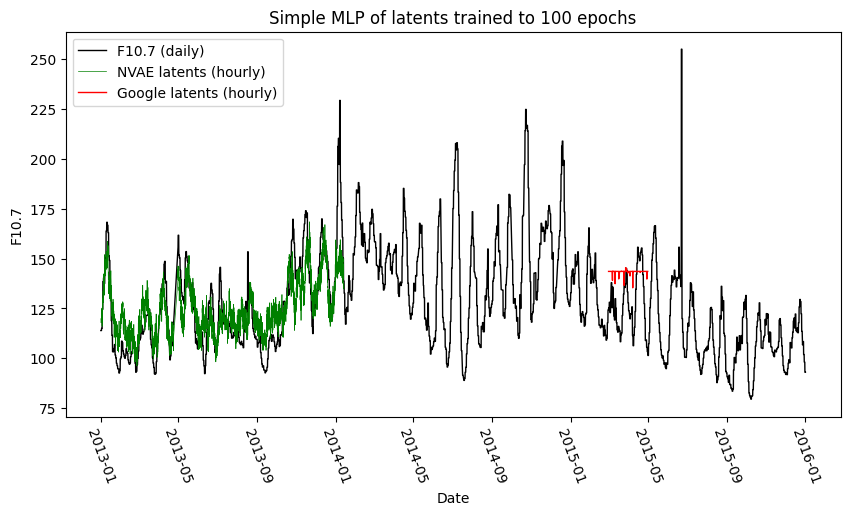

In [315]:
# hfont = {'fontname':'Helvetica'}
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 5))
# plt.plot([pd.to_datetime(i, format="%Y-%m-%d_%H:%M:%S") for i in nvae_latents_dataloader_ready_matched.keys()], f107_for_daily_nvae, label="F10.7 (daily)")
plt.plot([pd.to_datetime(i, format="%Y-%m-%d_%H:%M:%S") for i in nvae_latents_dataloader_ready_matched.keys()], f107_for_daily_nvae, label="F10.7 (daily)", linewidth=1, c="black")
p_x = [pd.to_datetime(i[0], format="%Y-%m-%d_%H:%M:%S") for i in tp.keys()]
plt.plot(p_x, p, label="NVAE latents (hourly)", linewidth=0.5, c="green")
plt.plot(tpg, np.array(preds_google).reshape(-1), label="Google latents (hourly)", linewidth=1, c="red")
plt.legend()
plt.xticks(rotation=290)
plt.ylabel("F10.7")
plt.xlabel("Date")
plt.title("Simple MLP of latents trained to 100 epochs")
# plt.xlim((np.min(p_x), np.max(p_x)))
plt.show()


In [280]:
tp = model.test_preds

y, preds = [], []
for i in tp.values():
    # i[0].detach().numpy()
    # print(i)
    # i[0] = i[0].cpu().detach().numpy()
    # i[1] = i[1].cpu().detach().numpy()
    # i[2] = i[2].cpu().detach().numpy()
    y.append(i[1].cpu().detach().numpy()[0])
    preds.append(i[2].cpu().detach().numpy()[0])


In [149]:
nvae_latents_dataloader_ready_matched.keys()

dict_keys(['2015-03-01_00:12:00', '2015-03-01_01:12:00', '2015-03-01_02:12:00', '2015-03-01_03:12:00', '2015-03-01_04:12:00', '2015-03-01_05:12:00', '2015-03-01_10:12:00', '2015-03-01_11:12:00', '2015-03-01_12:12:00', '2015-03-01_13:12:00', '2015-03-01_14:12:00', '2015-03-01_15:12:00', '2015-03-01_16:12:00', '2015-03-01_17:12:00', '2015-03-01_19:12:00', '2015-03-01_20:12:00', '2015-03-01_21:12:00', '2015-03-01_22:12:00', '2015-03-01_23:12:00', '2015-03-02_00:12:00', '2015-03-02_01:12:00', '2015-03-02_02:12:00', '2015-03-02_03:12:00', '2015-03-02_04:12:00', '2015-03-02_05:12:00', '2015-03-02_10:12:00', '2015-03-02_11:12:00', '2015-03-02_12:12:00', '2015-03-02_13:12:00', '2015-03-02_14:12:00', '2015-03-02_15:12:00', '2015-03-02_16:12:00', '2015-03-02_17:12:00', '2015-03-02_19:12:00', '2015-03-02_20:12:00', '2015-03-02_21:12:00', '2015-03-02_22:12:00', '2015-03-02_23:12:00', '2015-03-06_00:12:00', '2015-03-06_01:12:00', '2015-03-06_02:12:00', '2015-03-06_03:12:00', '2015-03-06_04:12:00', 

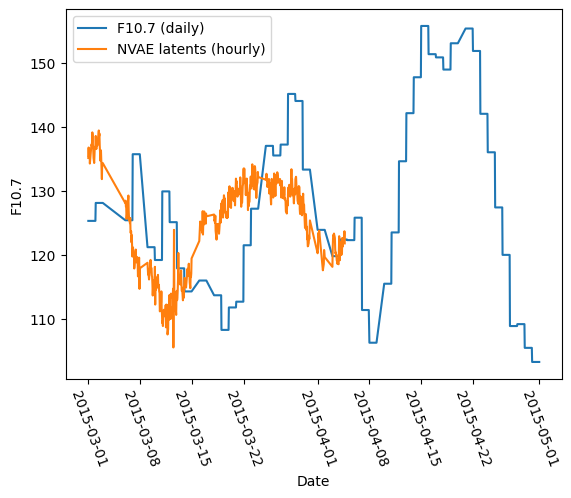

In [152]:
# plt.plot(f107_for_daily_nvae)
plt.plot([pd.to_datetime(i, format="%Y-%m-%d_%H:%M:%S") for i in nvae_latents_dataloader_ready_matched.keys()], f107_for_daily_nvae, label="F10.7 (daily)")
plt.plot([pd.to_datetime(i[0], format="%Y-%m-%d_%H:%M:%S") for i in tp.keys()], preds, label="NVAE latents (hourly)")
plt.legend()
plt.xticks(rotation=290)
plt.ylabel("F10.7")
plt.xlabel("Date")
plt.show()

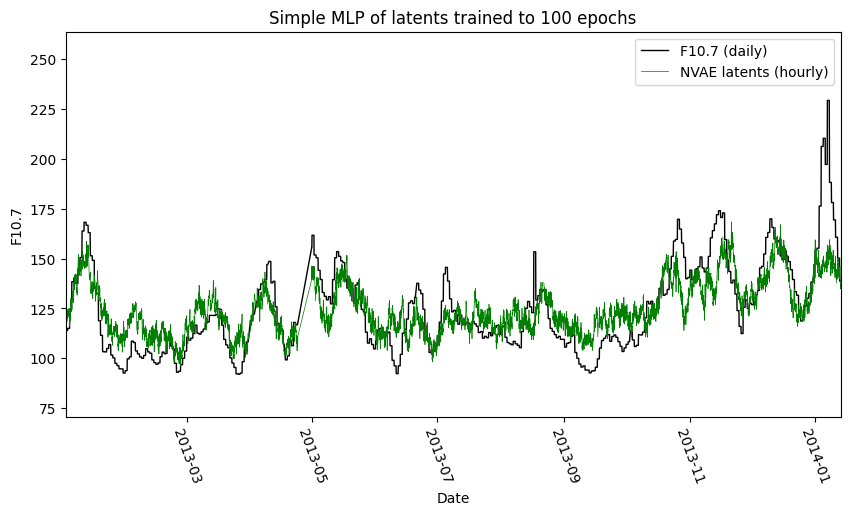

In [207]:
# hfont = {'fontname':'Helvetica'}
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 5))
# plt.plot([pd.to_datetime(i, format="%Y-%m-%d_%H:%M:%S") for i in nvae_latents_dataloader_ready_matched.keys()], f107_for_daily_nvae, label="F10.7 (daily)")
plt.plot([pd.to_datetime(i, format="%Y-%m-%d_%H:%M:%S") for i in nvae_latents_dataloader_ready_matched.keys()], f107_for_daily_nvae, label="F10.7 (daily)", linewidth=1, c="black")
p_x = [pd.to_datetime(i[0], format="%Y-%m-%d_%H:%M:%S") for i in tp.keys()]
plt.plot(p_x, p, label="NVAE latents (hourly)", linewidth=0.5, c="green")
plt.legend()
plt.xticks(rotation=290)
plt.ylabel("F10.7")
plt.xlabel("Date")
plt.title("Simple MLP of latents trained to 100 epochs")
plt.xlim((np.min(p_x), np.max(p_x)))
plt.show()


In [190]:
p = np.array(preds).reshape(-1)
p.min()

96.12925437402284

In [185]:
p.argmax()

2500

In [210]:
nvae_latents_dataloader_ready_matched['2013-01-01_01:12:00'].shape

(21504,)

In [191]:
p[7276] = p[7275]
p[2500] = p[2499]

In [187]:
p.max()

168.42039176471673

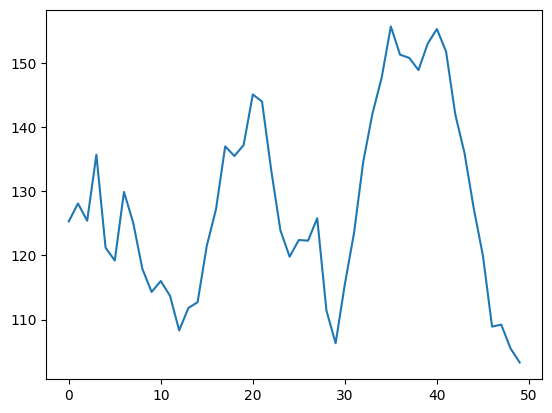

In [100]:
import matplotlib.pyplot as plt
plt.plot(list(f107.values()))